Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [229]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [188]:
'''
The traditional Nim-game (aka Marienbad-game) consists of four rows of 1, 3, 5 and 7 matchsticks 
(or any other objects). Two players take any number of matchsticks from one row alternately. 
The one, who takes the last matchstick loses. 
'''



class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In the "pure_random" and "gabriele" approach we proceed with the worst methods to wind the game. We have to seek for better strategies. 

In [11]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [12]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [13]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


### Nim Sum
Count the matchsticks in each row... And convert them mentally in multiples of 4, 2 and 1. Then, CANCEL pairs of equal multiples, and add what is left. To win at Nim-game, always make a move, whenever possible, that leaves a configuration with a ZERO “Nim sum”, that is with ZERO unpaired multiple(s) of 4, 2 or 1. Otherwise, your opponent has the advantage, and you have to depend on his/her committing an error in order to win.


In [27]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked

'''
In the optimal method we try to make our oponent in a position which nim_sum is not equal zero. After
we collect all the possible moves with ns!=0, we randomly select from available possible moves.
'''

def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [28]:
'''
Now the first player use Optimal algorithm to win. After few run, we notice pure_random algorithm win
the oprimal solution. To address the issue we first analyze the wining_rate after 50 epochs to measure
the performance our evaluation. We consider two procedures:
    
    1- Optimal plays first
    2- Pure Random palys first
'''


logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(6)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
    
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=10)
INFO:root:status: <1 3 5 7 9 1>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=1)
INFO:root:status: <1 3 5 7 9 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=6)
INFO:root:status: <1 3 5 1 9 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=5)
INFO:root:status: <1 3 0 1 9 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=5)
INFO:root:status: <1 3 0 1 4 0>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 0 1 4 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 1 0 1 4 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 1 0 1 2 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 0 0 1 2 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 0 2 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1

In [24]:
nim = Nim(6)
nim.rows

(1, 3, 5, 7, 9, 11)

In [16]:
algorithms = {
    'pure_random': pure_random,
    'gabriele': gabriele,
    'optimal': optimal
}


def play_nim(strategy, epochs: int) -> None:
    player_0 = strategy[0]
    player_1 = strategy[1]
    scores = {}
    scores[0] = {}
    scores[1] = {}
    scores[0][player_0] = 0
    scores[1][player_0] = 0
    scores[0][player_1] = 0
    scores[1][player_1] = 0
    strategy = (algorithms[player_0], algorithms[player_1])

    for _ in range(epochs):
        for strat in [0,1]:
            nim = Nim(5)
            player = strat
            while nim:
                ply = strategy[player](nim)
                nim.nimming(ply)
                player = 1 - player

            if player == 0:
                scores[strat][player_0]+=1
            else:
                scores[strat][player_1]+=1
        
    print(f'==== Comparing "{player_0}" and "{player_1}" algorithms ====\n')
    print(f'If player with "{player_0}" algorthim starts:')
    print(f'Win percebtage for "{player_0}" player is: {round((scores[0][player_0]/epochs)*100, 2)}%')
    print(f'Win percebtage for "{player_1}" player is: {round((scores[0][player_1]/epochs)*100, 2)}%\n')
    print(20*'----')
    print(f'\nIf player with "{player_1}" algorthim starts:')
    print(f'Win percebtage for "{player_0}" player is: {round((scores[1][player_0]/epochs)*100, 2)}%')
    print(f'Win percebtage for "{player_1}" player is: {round((scores[1][player_1]/epochs)*100, 2)}%')

In [17]:
strategy = ('optimal', 'pure_random')
epochs = 100

play_nim(strategy, epochs)

'''
We can see that "optimal" algorithm works better than randomly selected moves.
However, we have the results are still poor. 
'''

==== Comparing "optimal" and "pure_random" algorithms ====

If player with "optimal" algorthim starts:
Win percebtage for "optimal" player is: 76.0%
Win percebtage for "pure_random" player is: 24.0%

--------------------------------------------------------------------------------

If player with "pure_random" algorthim starts:
Win percebtage for "optimal" player is: 64.0%
Win percebtage for "pure_random" player is: 36.0%


'\nWe can see that "optimal" algorithm works better than randomly selected moves.\nHowever, we have the results are still poor. \n'

In [301]:
strategy = ('optimal', 'gabriele')
epochs = 100

play_nim(strategy, epochs)

'''
Compared to "gabriele" algorithm we have better results in optimal. 
Gabriele, is an absolute non-effective algorithm.
'''

==== Comparing "optimal" and "gabriele" algorithms ====

If player with "optimal" algorthim starts:
Win percebtage for "optimal" player is: 86.0%
Win percebtage for "gabriele" player is: 14.0%

--------------------------------------------------------------------------------

If player with "gabriele" algorthim starts:
Win percebtage for "optimal" player is: 86.0%
Win percebtage for "gabriele" player is: 14.0%


## TASK 2.1

In the first task we want to optimize an agent using fixed rules based on nim-sum (i.e., an expert system). I have managed to define three algorithms to address NIM game:

    1- min_optimal : In this method, e select the first move which have the minimum nim_sum and it is not zero (if exists)
    
    2- min_optimal_odd : Like min_optimal, except we consider minimum odd move
    
    3- min_optimal_even : Like min_optimal, except we consider minimum even move
    
At the end I will try to compare the results for each algorithm with previous algorithms.

In [289]:
'''
We now define a new algorithm.
'''


def min_optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    all_moves = [(ply, ns) for ply, ns in analysis["possible_moves"].items()]
    spicy_moves = sorted(all_moves, key=lambda x:x[1])
    lowest_sn_not_zero = 0 
    for mov in spicy_moves: 
        if mov[1] != 0:
            lowest_sn_not_zero = mov[1]
            break
    new_sm = [mov for mov in spicy_moves if mov[1]==lowest_sn_not_zero]
    return new_sm[-1][0]

algorithms['min_optimal'] = min_optimal

In [290]:
strategy = ('min_optimal', 'pure_random')
epochs = 100

play_nim(strategy, epochs)

'''
We have great results on this approach. We outperform the 'optimal' version.
'''

==== Comparing "min_optimal" and "pure_random" algorithms ====

If player with "min_optimal" algorthim starts:
Win percebtage for "min_optimal" player is: 91.0%
Win percebtage for "pure_random" player is: 9.0%

--------------------------------------------------------------------------------

If player with "pure_random" algorthim starts:
Win percebtage for "min_optimal" player is: 93.0%
Win percebtage for "pure_random" player is: 7.0%


In [304]:
strategy = ('min_optimal', 'optimal')
epochs = 100

play_nim(strategy, epochs)

'''
With the min_optimal method we always win against proposed 'optimal' method.
''' 

==== Comparing "min_optimal" and "optimal" algorithms ====

If player with "min_optimal" algorthim starts:
Win percebtage for "min_optimal" player is: 100.0%
Win percebtage for "optimal" player is: 0.0%

--------------------------------------------------------------------------------

If player with "optimal" algorthim starts:
Win percebtage for "min_optimal" player is: 100.0%
Win percebtage for "optimal" player is: 0.0%


In [279]:
def min_optimal_even(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    all_moves = [(ply, ns) for ply, ns in analysis["possible_moves"].items()]
    spicy_moves = sorted(all_moves, key=lambda x:x[1])
    lowest_sn_not_zero = 0 
    for mov in spicy_moves: 
        if mov[1] != 0 and mov[1]%2 == 0:
            lowest_sn_not_zero = mov[1]
            break
    new_sm = [mov for mov in spicy_moves if mov[1]==lowest_sn_not_zero]
    if len(new_sm)==0:
        return spicy_moves[0][0]
    return new_sm[-1][0]

algorithms['min_optimal_even'] = min_optimal_even

In [280]:
strategy = ('min_optimal_even', 'pure_random')
epochs = 100

play_nim(strategy, epochs)

'''
We obtain very bad results. However, we conclude that selecting even nim_sums lower the performance.
'''

==== Comparing "min_optimal_even" and "pure_random" algorithms ====

If player with "min_optimal_even" algorthim starts:
Win percebtage for "min_optimal_even" player is: 48.0%
Win percebtage for "pure_random" player is: 52.0%

--------------------------------------------------------------------------------

If player with "pure_random" algorthim starts:
Win percebtage for "min_optimal_even" player is: 58.0%
Win percebtage for "pure_random" player is: 42.0%


In [284]:
def min_optimal_odd(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    all_moves = [(ply, ns) for ply, ns in analysis["possible_moves"].items()]
    spicy_moves = sorted(all_moves, key=lambda x:x[1])
    lowest_sn_not_zero = 0 
    for mov in spicy_moves: 
        if mov[1] != 0 and mov[1]%2 == 1:
            lowest_sn_not_zero = mov[1]
            break
    new_sm = [mov for mov in spicy_moves if mov[1]==lowest_sn_not_zero]
    if len(new_sm)==0:
        return spicy_moves[0][0]
    return new_sm[-1][0]

algorithms['min_optimal_odd'] = min_optimal_odd

In [302]:
strategy = ('min_optimal_odd', 'pure_random')
epochs = 100

play_nim(strategy, epochs)


'''
We obtain best results. We managed to win 97% of the times over 200 epoch on average.
'''

==== Comparing "min_optimal_odd" and "pure_random" algorithms ====

If player with "min_optimal_odd" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 96.0%
Win percebtage for "pure_random" player is: 4.0%

--------------------------------------------------------------------------------

If player with "pure_random" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 98.0%
Win percebtage for "pure_random" player is: 2.0%


In [303]:
strategy = ('min_optimal_odd', 'optimal')
epochs = 100

play_nim(strategy, epochs)


'''
With the min_optimal_odd method we always win against proposed 'optimal' method.
''' 

==== Comparing "min_optimal_odd" and "optimal" algorithms ====

If player with "min_optimal_odd" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 100.0%
Win percebtage for "optimal" player is: 0.0%

--------------------------------------------------------------------------------

If player with "optimal" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 100.0%
Win percebtage for "optimal" player is: 0.0%


In [294]:
'''
Now let's compare two best approaches until now.
'''

strategy = ('min_optimal_odd', 'min_optimal')
epochs = 100

play_nim(strategy, epochs)

'''
We can see that selecting lower odd number always wins the 'min_optimal' method.
'''

==== Comparing "min_optimal_odd" and "min_optimal" algorithms ====

If player with "min_optimal_odd" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 100.0%
Win percebtage for "min_optimal" player is: 0.0%

--------------------------------------------------------------------------------

If player with "min_optimal" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 0.0%
Win percebtage for "min_optimal" player is: 100.0%


In [295]:
strategy = ('min_optimal_odd', 'gabriele')
epochs = 100

play_nim(strategy, epochs)

==== Comparing "min_optimal_odd" and "gabriele" algorithms ====

If player with "min_optimal_odd" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 100.0%
Win percebtage for "gabriele" player is: 0.0%

--------------------------------------------------------------------------------

If player with "gabriele" algorthim starts:
Win percebtage for "min_optimal_odd" player is: 100.0%
Win percebtage for "gabriele" player is: 0.0%


In [305]:
strategy = ('min_optimal', 'gabriele')
epochs = 100

play_nim(strategy, epochs)

==== Comparing "min_optimal" and "gabriele" algorithms ====

If player with "min_optimal" algorthim starts:
Win percebtage for "min_optimal" player is: 100.0%
Win percebtage for "gabriele" player is: 0.0%

--------------------------------------------------------------------------------

If player with "gabriele" algorthim starts:
Win percebtage for "min_optimal" player is: 100.0%
Win percebtage for "gabriele" player is: 0.0%


## TASK 1.2.
<br>
<br>

In this task I will try analyze three methods provided by Prof. in lectures. The methods are used:
<br>
<br>
<br>
$$ Population\ size\ \  (vanilla): (1 + \lambda) $$
$$ Population\ size\ \  (adaptive): (1 + \lambda) $$ 
$$ Population\ size\ \  (adaptive): (\mu + \lambda) $$
<br>
<br>
<br>
Now we start analysis by creating and evoluted agent using Evolutionary Algorithms. I want to develop algorithms using below definitions:
<br>
<br>
$$ f(w) = \frac{1}{2}\left[ \left| \sum_{n=1}^{E}w(w) \right|_{s=0}  +  \left| \sum_{n=1}^{E}w(w) \right|_{s=1} \right] $$
$$ g(a) = (row,\ num\_objects,\ future\_nim\_sum) $$
$$ s(a, w) = \sum_{j=0}^{D}  g(a)\bigotimes_{} w_{ij}  $$
<br>
<br>    
In above formulations, $f(w)$ stands for the total fitness of the agent and $w(w)$ represent the winning status of the agent for a specific weight. The total objective will be calculated over $E$ number of epochs. In each epoch agent choose an action based on it's weights associated to it. Each action consist of three chromosomes. The $g(a)$ describe the chromosomes features of an action, where action $a \in \mathbb{R}^{A} $and$ A $is number of actions available for the agent. The scores of each step will be calculated by $s(a, w)$. Action with the highest score will be chosen. After the game is over, $w(w)$ will be calculated (0 or 1) for each game. We repeat the process with two possible starts $s$. The final score is averaged over number of wins. Best weight in population is selected for adding to the new population $ \lambda$. Moreover, $D$ denotes as the dimension of the weight.
<br>
<br>
<br>
<br> 
### 1.2.1 First Method: Vanila-ES (1 + $\lambda$)


In [285]:
def genome(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    moves = np.array([[ply.row, ply.num_objects, ns] for ply, ns in analysis["possible_moves"].items()])
    return moves

def weights_initalization(weights_dim: int) -> tuple:
    weights = np.random.rand(3,weights_dim) * 5.12 * 2 - 5.12
    projection_weights = np.random.rand(weights_dim,1)
    return (weights, projection_weights)

def create_population(mu, σ, weights_dim: int):
    population = np.random.rand(mu,3,weights_dim+1)
    population[:,:, :-1] = population[:,:, :-1] * 5.12 * 2 - 5.12
    population[:,:, -1] *= σ
    return population

def z_norm(outputs: np.array):
    mean = np.mean(output, axis=0).shape
    std = np.std(output, axis=0).shape
    return (output - mean) / std

def es(state, weights):
    moves = genome(state)
    output = moves @ weights
    return Nimply(int(moves[np.argmin(output.sum(axis=1))][0]), int(moves[np.argmin(output.sum(axis=1))][1]))
    
    
def objective(weights_list, opponent_strategy, epochs, nim_dim):
    scores_first = 0
    scores_second = 0
    all_scores = []
    opponent_strategy = algorithms[opponent_strategy]
    
    for weight in weights_list:
        scores_first = 0
        scores_second = 0
        for _ in range(epochs):
            for strat in [1,0]:
                nim = Nim(nim_dim)
                player = strat
                while nim:
                    if player == 1:
                        ply = opponent_strategy(nim)
                    else:
                        ply = es(nim, weights)
                    nim.nimming(ply)
                    player = 1 - player

                if player == 0:
                    if strat == 0:
                        scores_first+=1
                        
                    else:
                        scores_second+=1
        all_scores.append([(scores_first + scores_second)/2])

        
    return np.array(all_scores)



100%|████████████████| 50/50 [03:49<00:00,  4.58s/it, Best Average Wins=11.0/20]
INFO:root:Best solution: 6.5


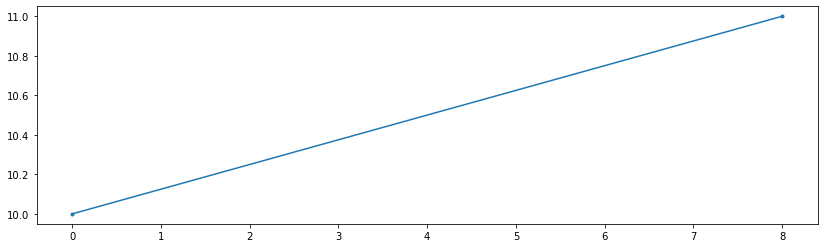

In [311]:
weights_dim = 5
genome_size = 3
nim_dim = 4
epochs = 20
λ = 20
σ = 0.6
opponent_strategy = 'optimal'


weights, _ = weights_initalization(weights_dim)
history = list()
best = np.copy(weights)
current_highest = objective(np.expand_dims(weights, axis=0), opponent_strategy, epochs, nim_dim)[0][0]
with trange(1_000 // λ) as t:
    for n in t:
        # offspring <- select λ random points mutating the current solution
        weights_list = (
            np.random.normal(loc=0, scale=σ, size=(λ, genome_size, weights_dim)) + weights
        )
        # evaluarte and select best
        evals = objective(weights_list, opponent_strategy, epochs, nim_dim)
        weights = weights_list[np.argmax(evals)]
        new_highest = np.max(evals)
        if current_highest < new_highest:
            best = np.copy(weights)
            current_highest = new_highest
            history.append((n, new_highest))

        t.set_postfix({f"Best Average Wins": f"{current_highest}/{epochs}"})

logging.info(f"Best solution: {objective(np.expand_dims(best, axis=0), opponent_strategy, epochs, nim_dim)[0][0]}")

if len(history) > 0:
    history = np.array(history)
    plt.figure(figsize=(14, 4))
    plt.plot(history[:, 0], history[:, 1], marker=".")

<br>
<br>
<br>
<br>

### 1.2.2 Second Method: Adaptive-ES (1 + $\lambda$)

100%|████████████████| 50/50 [04:57<00:00,  5.94s/it, Best Average Wins=18.0/30]
INFO:root:Best solution: 10.0


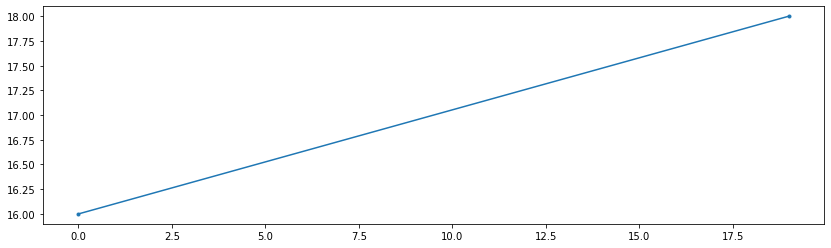

In [317]:
weights_dim = 3
genome_size = 3
nim_dim = 4
epochs = 30
λ = 30
σ = 0.15
opponent_strategy = 'optimal'


weights, _ = weights_initalization(weights_dim)
history = list()
best = np.copy(weights)
current_highest = objective(np.expand_dims(weights, axis=0), opponent_strategy, epochs, nim_dim)[0][0]


stats = [0, 0]
with trange(1500 // λ) as t:
    for step in t:
        weights_list = (
            np.random.normal(loc=0, scale=σ, size=(λ, genome_size, weights_dim)) + weights
        )
        evals = objective(weights_list, opponent_strategy, epochs, nim_dim)
        stats[0] += λ
        stats[1] += sum(evals > objective(np.expand_dims(weights, axis=0), opponent_strategy, epochs, nim_dim)[0][0])
        weights = weights_list[np.argmax(evals)]
        new_highest = np.max(evals)
        
        if current_highest < new_highest:
            best = np.copy(weights)
            current_highest = new_highest
            history.append((step, new_highest))
            
        if (step + 1) % 5 == 0:
            if stats[0] / stats[1] < 1 / 5:
                σ /= 1.2
            elif stats[0] / stats[1] > 1 / 5:
                σ *= 1.2
            steps = [0, 0]
        t.set_postfix({f"Best Average Wins": f"{current_highest}/{epochs}"})
        
        
logging.info(f"Best solution: {objective(np.expand_dims(best, axis=0), opponent_strategy, epochs, nim_dim)[0][0]}")

if len(history) > 0:
    history = np.array(history)
    plt.figure(figsize=(14, 4))
    plt.plot(history[:, 0], history[:, 1], marker=".")

<br>
<br>
<br>
<br>

### 1.2.3 Third Method: Adaptive-ES ($\mu$ + $\lambda$)

100%|████████████████| 50/50 [04:51<00:00,  5.84s/it, Best Average Wins=17.0/30]
INFO:root:Best solution: 12.0 (with σ=[ 3.98555917  6.61264541 -2.60922271  0.91932835])


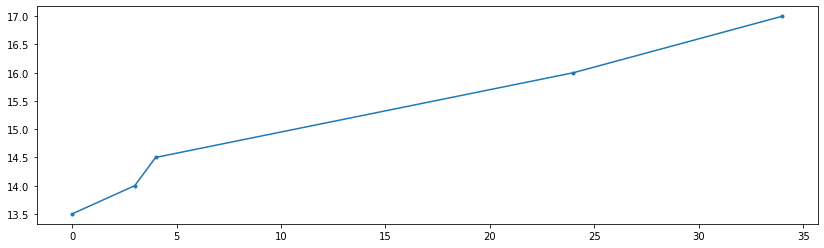

In [315]:
μ = 20
λ = 30
σ = 1
weights_dim = 3
genome_size = 3
nim_dim = 4
epochs = 30
opponent_strategy = 'optimal'


population = create_population(μ, σ, weights_dim)

best_fitness = None
history = list()
with trange(1500 // λ) as t:
    for step in t:
        # offspring <- select λ random points from the population of μ
        offspring = population[np.random.randint(0, μ, size=(λ,))]
        # mutate all σ (last column) and replace negative values with a small number
        offspring[:,:, -1] = np.random.normal(
            loc=offspring[:,:, -1], scale=0.2
        )
        offspring[offspring[:,:, -1] < 1e-5, -1] = 1e-5
        # mutate all v (all columns but the last), using the σ in the last column
        offspring[:,:, 0:-1] = np.random.normal(
            loc=offspring[:,:, 0:-1], scale=np.expand_dims(offspring[:,:, -1], axis=2)
        )
        # add an extra column with the evaluation and sort
        fitness = objective(offspring[:,:, 0:-1], opponent_strategy, epochs, nim_dim)
        offspring = offspring[fitness.argsort().reshape(-1)]
        # save best (just for the plot)
        if best_fitness is None or best_fitness < np.max(fitness):
            best_fitness = np.max(fitness)
            history.append((step, best_fitness))
        # select the μ with max fitness and discard fitness
        population = np.copy(offspring[-μ:])
        t.set_postfix({f"Best Average Wins": f"{best_fitness}/{epochs}"})

        
fitness = objective(population[:, 0:-1], opponent_strategy, epochs, nim_dim)
logging.info(
    f"Best solution: {fitness.max()} (with σ={population[fitness.argmax(), -1]})"
)

if len(history) > 0:
    history = np.array(history)
    plt.figure(figsize=(14, 4))
    plt.plot(history[:, 0], history[:, 1], marker=".")